# Stability optimization

In the previous notebook, we set the hyperparameter C to a specific value when training the elastic net. Typically, it is recommended to optimize hyperparameters using validation data (e.g., by nested cross-validation). The standard optimization criterion is the prediction accuracy on the validation data. Let us try this on the tomato dataset for the species prediction task.

Click on the button below to open this notebook in the Colab environment.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/DimRed-Course/blob/main/notebooks/5_stability_optimization.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

data_with_labels = pd.read_csv("../data/tomato_with_targets.txt", index_col=0)
labels = ['species','position','tissue','root']
data_original = data_with_labels.drop(columns = labels, axis = 1).to_numpy()
target = data_with_labels['species'].to_numpy()

The following code snippet showcases the framework of hyperparameter optimization. For efficient applications in practice, it is recommended to use vectorized code instead of nested for loops.

In [2]:
def optimize_C(do_selection = lambda a, b : np.argmax(a), C_values=np.power(np.exp(1), np.flip(np.linspace(-2.5, 0, 10).astype(float)))): 

    print(C_values)

    tissue_types = data_with_labels['tissue'].unique()
    num_selected_pos = np.zeros(len(tissue_types))
    num_selected_neg = np.zeros(len(tissue_types))
    for o in range(len(tissue_types)):
        print(f"Test tissue: {tissue_types[o]}")
        wtest = np.where(data_with_labels['tissue']==tissue_types[o])[0]
        tissue_types_train = np.setdiff1d(tissue_types, tissue_types[o])
        
        performances = np.zeros((len(tissue_types_train), len(C_values)))
        stability_scores = np.zeros((len(tissue_types_train), len(C_values)))
        
        for k in range(len(C_values)):
            num_selected_pos = np.zeros(len(tissue_types_train))
            num_selected_neg = np.zeros(len(tissue_types_train))
            for i in range(len(tissue_types_train)):
                wval = np.where(data_with_labels['tissue']==tissue_types_train[i])[0]
                wtrain = np.setdiff1d(range(data_with_labels.shape[0]), np.append(wval, wtest))

                scaler = StandardScaler().set_output(transform="default")
                data_train = scaler.fit_transform(data_original[wtrain,:])
                logistic = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, C=C_values[k], tol=0.01, random_state=42)
                logistic.fit(data_train, target[wtrain])
                selected_curr_pos = np.where(logistic.coef_.reshape(-1, 1)>0)[0]
                selected_curr_neg = np.where(logistic.coef_.reshape(-1, 1)<0)[0]
                if (i==0): 
                    selected_all_pos = selected_curr_pos
                    selected_all_neg = selected_curr_neg
                else:
                    selected_all_pos = np.intersect1d(selected_all_pos, selected_curr_pos) 
                    selected_all_neg = np.intersect1d(selected_all_neg, selected_curr_neg)           
                num_selected_pos[i] = len(selected_curr_pos)
                num_selected_neg[i] = len(selected_curr_neg)
        
                data_val = scaler.transform(data_original[wval,:]) # transform with scaling parameters determined on training data
                pred = logistic.predict(data_val)

                performances[i, k] = accuracy_score(target[wval], pred)
            for i in range(len(tissue_types_train)):
                if num_selected_pos[i]>0 and num_selected_neg[i]>0:
                    stability_scores[i, k] = ((len(selected_all_pos)/num_selected_pos[i]) + (len(selected_all_neg)/num_selected_neg[i]))/2
            
        avg_performance = np.apply_along_axis(np.mean, 0, performances)
        avg_stability = np.apply_along_axis(np.mean, 0, stability_scores)
       
        best_index = do_selection(avg_performance, avg_stability)
        print(f"Best C: {C_values[best_index]}")
        
        # plot
        plt.rcParams["figure.figsize"] = (3,2) 
        plt.plot(avg_stability, avg_performance, marker='o', linestyle='--')
        plt.xlabel('Stability')
        plt.ylabel('Accuracy')
        plt.title("Validation set metrics")
        plt.plot(avg_stability[best_index], avg_performance[best_index], marker="s", color="red")
        plt.show()
        # retrain model with selected features on whole training data and test performance
        wtrain_outer = np.setdiff1d(range(data_with_labels.shape[0]), wtest)
        scaler = StandardScaler().set_output(transform="default")
        data_train_outer = scaler.fit_transform(data_original[wtrain_outer,:])
        logistic = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, C=C_values[best_index], tol=0.01, random_state=42)
        logistic.fit(data_train_outer, target[wtrain_outer])

        data_test = scaler.transform(data_original[wtest,:]) # transform with scaling parameters determined on training data
        pred = logistic.predict(data_test)
        accuracy = accuracy_score(target[wtest], pred)
        print(f"Test accuracy: {accuracy}\n")

[1.         0.75746513 0.57375342 0.43459821 0.32919299 0.24935221
 0.1888756  0.14306668 0.10836802 0.082085  ]
Test tissue: floral
Best C: 1.0


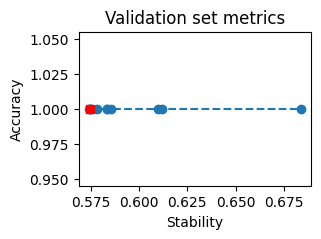

Test accuracy: 1.0

Test tissue: leaf
Best C: 1.0


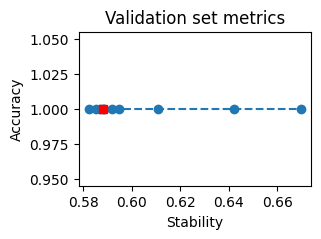

Test accuracy: 1.0

Test tissue: root
Best C: 1.0


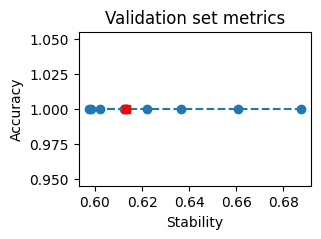

Test accuracy: 1.0

Test tissue: sdling
Best C: 1.0


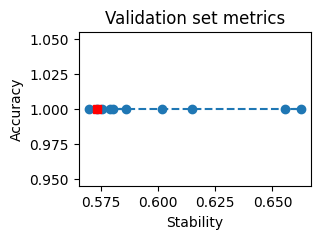

Test accuracy: 1.0

Test tissue: stem
Best C: 1.0


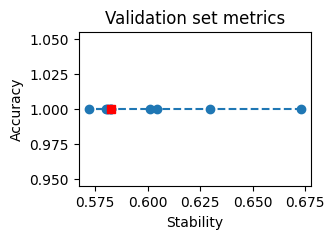

Test accuracy: 1.0

Test tissue: veg
Best C: 1.0


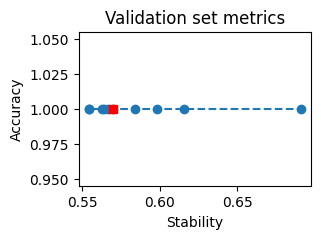

Test accuracy: 1.0



In [3]:
optimize_C()

The red square corresponds to the selected C value. We see that the optimization of accuracy can yield results with suboptimal stability. The curves indicate that there exist solutions that have more stable feature selection without sacrificing performance. We will now use the sum of accuracy and stability as a simple optimization criterion.

[1.         0.75746513 0.57375342 0.43459821 0.32919299 0.24935221
 0.1888756  0.14306668 0.10836802 0.082085  ]
Test tissue: floral
Best C: 0.0820849986238988


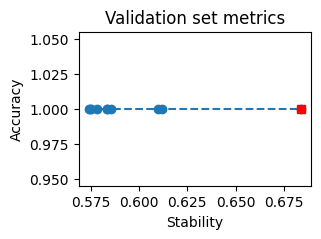

Test accuracy: 1.0

Test tissue: leaf
Best C: 0.0820849986238988


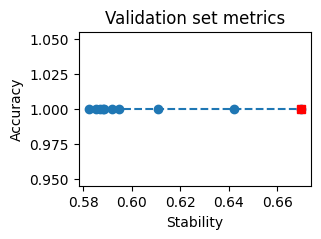

Test accuracy: 1.0

Test tissue: root
Best C: 0.0820849986238988


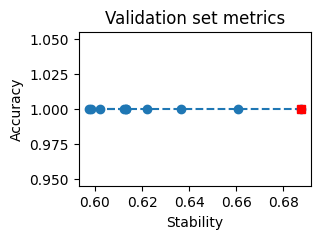

Test accuracy: 1.0

Test tissue: sdling
Best C: 0.10836802322189587


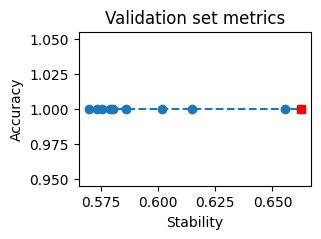

Test accuracy: 1.0

Test tissue: stem
Best C: 0.0820849986238988


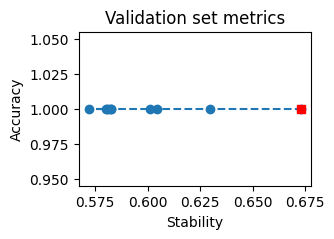

Test accuracy: 1.0

Test tissue: veg
Best C: 0.0820849986238988


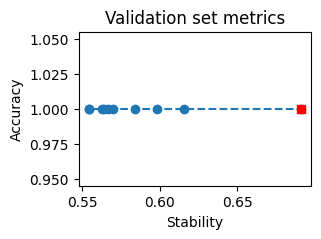

Test accuracy: 1.0



In [4]:
optimize_C(do_selection = lambda a, b : np.argmax(a+b))

Now, always the C parameter with top stability got selected and the test accuracy is still perfect. Of course, due to the simplicity of the classification task, this analysis was rather trivial. Let us try with a more complicated task where only a subset of genes is given.

In [5]:
data_original = data_with_labels.drop(columns = labels, axis = 1)
def extract_part(x, part, spl='.'):
    s = [elem.split(spl) for elem in x]
    return [elem[part] for elem in s]
df = pd.DataFrame(data_original)
df.columns = extract_part(data_original.columns, part=0)
rd = pd.read_csv("../data/goslim_to_genes.txt", header=0, delimiter='\t')

def get_data(go):
    w = rd[rd['GO term']==go].index[0]
    s = rd.iloc[w, 1].split(',')
    dat1raw = df.loc[:, df.columns.intersection(s)]
    return(dat1raw)

[0.75, 0.5, 0.25, 0.1, 0.0875]
Test tissue: floral
Best C: 0.0875


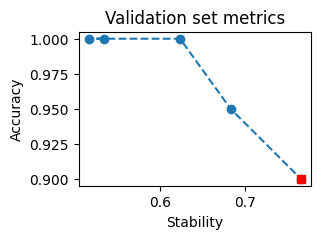

Test accuracy: 1.0

Test tissue: leaf
Best C: 0.1


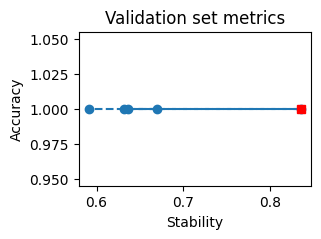

Test accuracy: 1.0

Test tissue: root
Best C: 0.0875


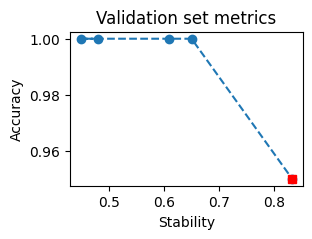

Test accuracy: 0.75

Test tissue: sdling
Best C: 0.0875


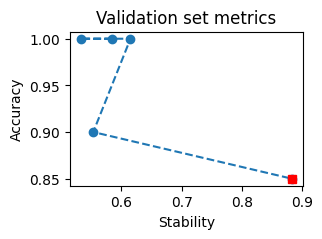

Test accuracy: 1.0

Test tissue: stem
Best C: 0.0875


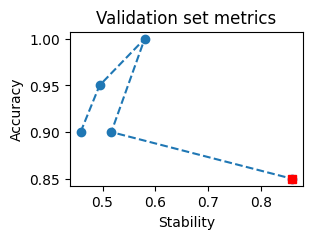

Test accuracy: 1.0

Test tissue: veg
Best C: 0.0875


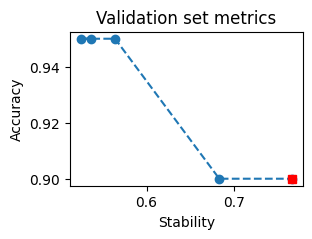

Test accuracy: 1.0



In [6]:
data_original = get_data("GO:0006412").to_numpy()
optimize_C(do_selection = lambda a, b : np.argmax(a+b), C_values=[0.75, 0.5, 0.25, 0.1, 0.0875])


With this optimization criterion, we reach stabilities up to 0.9, at the expense of validation accuracy and partially also test accuracy.

### Task
1. Now try different variants of the optimization criterion (e.g., a weighted sum of stability and accuracy, or maximum stability for a given accuracy threshold). What is your recommendation to proceed with this, for the current data and in general?
2. There are many options to define stability. What is the drawback of our stability definition? Take a look at these two papers if you are further interested in the topic:
    - [Stability quantification](https://www.jmlr.org/papers/volume18/17-514/17-514.pdf)
    - [An importance-weighted stability measure](https://jmlr.org/papers/volume22/20-366/20-366.pdf)